In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [2]:
N_wn = 20
lbound_wn = 0
ubound_wn = 10
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

# Rotation

In [3]:
ellipsoid = bempp.api.shapes.ellipsoid(r1 = 0.3, r2 = 0.3, r3 = 0.6, origin = (0, 0, 0), h = 0.05)
ele_ellipsoid = ellipsoid.elements
ver_ellipsoid = ellipsoid.vertices

In [4]:
Cas_ = []
for rotation_angle in np.linspace(0, np.pi*2, 40):
    
    #Ellipsoid 1 
    angle_x_1 = rotation_angle
    R_x_1 = [[1, 0, 0], [0, np.cos(angle_x_1),  -np.sin(angle_x_1)], [0,  np.sin(angle_x_1),  np.cos(angle_x_1)]]

    angle_z_1 = np.arctan(np.sqrt(3)/3)
    R_z_1 = [[np.cos(angle_z_1), -np.sin(angle_z_1), 0], [np.sin(angle_z_1), np.cos(angle_z_1), 0], [0, 0, 1]]

    ver_ellipsoid1 = np.zeros((ver_ellipsoid.shape[0], ver_ellipsoid.shape[1]))
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid1[:,i] = R_z_1 @ (R_x_1 @ ver_ellipsoid[:,i])
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid1[1, i] -= 1
    ellipsoid_1_4_rotated = bempp.api.Grid(ver_ellipsoid1, ele_ellipsoid)

    #Ellipsoid 2 
    angle_x_2 = -rotation_angle
    R_x_2 = [[1, 0, 0], [0, np.cos(angle_x_2),  -np.sin(angle_x_2)], [0,  np.sin(angle_x_2),  np.cos(angle_x_2)]]

    angle_z_2 = -np.arctan(np.sqrt(3)/3)
    R_z_2 = [[np.cos(angle_z_2), -np.sin(angle_z_2), 0], [np.sin(angle_z_2), np.cos(angle_z_2), 0], [0, 0, 1]]

    ver_ellipsoid2 = np.zeros((ver_ellipsoid.shape[0], ver_ellipsoid.shape[1]))
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid2[:,i] = R_z_2 @ (R_x_2 @ ver_ellipsoid[:,i])
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid2[1, i] += 1
    ellipsoid_2_4_rotated = bempp.api.Grid(ver_ellipsoid2, ele_ellipsoid)

    #Ellipsoid 3 
    angle_y_3 = -rotation_angle
    R_y_3 = [[np.cos(angle_y_3), 0, np.sin(angle_y_3)], [0, 1, 0], [-np.sin(angle_y_3), 0,  np.cos(angle_y_3)]]

    ver_ellipsoid3 = np.zeros((ver_ellipsoid.shape[0], ver_ellipsoid.shape[1]))
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid3[:,i] = R_y_3 @ ver_ellipsoid[:,i]
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid3[0, i] -= np.sqrt(3)
    ellipsoid_3_4_rotated = bempp.api.Grid(ver_ellipsoid3, ele_ellipsoid)

    #Ellipsoid 4 
    angle_x_4 = rotation_angle
    R_x_4 = [[1, 0, 0], [0, np.cos(angle_x_4),  -np.sin(angle_x_4)], [0,  np.sin(angle_x_4),  np.cos(angle_x_4)]]

    ver_ellipsoid4 = np.zeros((ver_ellipsoid.shape[0], ver_ellipsoid.shape[1]))
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid4[:,i] = R_x_4 @ ver_ellipsoid[:,i]
    for i in range(ver_ellipsoid.shape[1]):
        ver_ellipsoid4[0, i] -= np.sqrt(3)/3
        ver_ellipsoid4[2, i] += 2*np.sqrt(6)/3
    ellipsoid_4_4_rotated = bempp.api.Grid(ver_ellipsoid4, ele_ellipsoid)

    
    space_ellipsoid1 =  bempp.api.function_space(ellipsoid_1_4_rotated,'P',1)
    space_ellipsoid2 =  bempp.api.function_space(ellipsoid_2_4_rotated,'P',1)
    space_ellipsoid3 =  bempp.api.function_space(ellipsoid_3_4_rotated,'P',1)
    space_ellipsoid4 =  bempp.api.function_space(ellipsoid_4_4_rotated,'P',1)
    
    results = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)
        
        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid1, space_ellipsoid1, space_ellipsoid1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid2, space_ellipsoid1, space_ellipsoid1, wavenumber)
        slp13 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid3, space_ellipsoid1, space_ellipsoid1, wavenumber)
        slp14 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid4, space_ellipsoid1, space_ellipsoid1, wavenumber)
        
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid1, space_ellipsoid2 , space_ellipsoid2 , wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid2, space_ellipsoid2 , space_ellipsoid2 , wavenumber)
        slp23 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid3, space_ellipsoid2 , space_ellipsoid2 , wavenumber)
        slp24 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid4, space_ellipsoid2 , space_ellipsoid2 , wavenumber)
        
        slp31 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid1, space_ellipsoid3 , space_ellipsoid3 , wavenumber)
        slp32 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid2, space_ellipsoid3 , space_ellipsoid3 , wavenumber)
        slp33 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid3, space_ellipsoid3 , space_ellipsoid3 , wavenumber)
        slp34 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid4, space_ellipsoid3 , space_ellipsoid3 , wavenumber)
        
        slp41 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid1, space_ellipsoid4 , space_ellipsoid4 , wavenumber)
        slp42 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid2, space_ellipsoid4 , space_ellipsoid4 , wavenumber)
        slp43 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid3, space_ellipsoid4 , space_ellipsoid4 , wavenumber)
        slp44 = bempp.api.operators.boundary.helmholtz.single_layer(space_ellipsoid4, space_ellipsoid4 , space_ellipsoid4 , wavenumber)


        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat13 = slp13.weak_form().A
        mat14 = slp14.weak_form().A
        
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat23 = slp23.weak_form().A
        mat24 = slp24.weak_form().A
        
        mat31 = slp31.weak_form().A
        mat32 = slp32.weak_form().A
        mat33 = slp33.weak_form().A
        mat34 = slp34.weak_form().A
        
        mat41 = slp41.weak_form().A
        mat42 = slp42.weak_form().A
        mat43 = slp43.weak_form().A
        mat44 = slp44.weak_form().A
        
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat13_zero = np.zeros((mat11.shape[0],mat13.shape[1]))
        mat14_zero = np.zeros((mat11.shape[0],mat14.shape[1]))
        
        mat21_zero = np.zeros((mat22.shape[0],mat21.shape[1]))
        mat23_zero = np.zeros((mat22.shape[0],mat23.shape[1]))
        mat24_zero = np.zeros((mat22.shape[0],mat24.shape[1]))
        
        mat31_zero = np.zeros((mat33.shape[0],mat31.shape[1]))
        mat32_zero = np.zeros((mat33.shape[0],mat32.shape[1]))
        mat34_zero = np.zeros((mat33.shape[0],mat34.shape[1]))
        
        mat41_zero = np.zeros((mat44.shape[0],mat41.shape[1]))
        mat42_zero = np.zeros((mat44.shape[0],mat42.shape[1]))
        mat43_zero = np.zeros((mat44.shape[0],mat43.shape[1]))

        mat = np.block([[mat11, mat12, mat13, mat14],
                        [mat21, mat22, mat23, mat24], 
                        [mat31, mat32, mat33, mat34], 
                        [mat41, mat42, mat43, mat44]])  
        
        mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
        mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))
        mat33_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat33), np.eye(mat33.shape[0]))
        mat44_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat44), np.eye(mat44.shape[0]))

        inv_free_mat2 = np.block([[mat11_inv,  mat12_zero, mat13_zero, mat14_zero],
                                  [mat21_zero, mat22_inv,  mat23_zero, mat24_zero],
                                  [mat31_zero, mat32_zero, mat33_inv,  mat34_zero],
                                  [mat41_zero, mat42_zero, mat43_zero, mat44_inv,]])  

        combined_inverse_free = inv_free_mat2.dot(mat)
        sign, logdet = slogdet(combined_inverse_free)

        results.append(logdet)
    print(rotation_angle, np.trapz(-np.array(results) / quad_points, quad_points) / (2 * np.pi))
    Cas_.append(np.trapz(-np.array(results) / quad_points, quad_points) / (2 * np.pi))

0.0 0.013213152737637226
0.16110731556870733 0.01290829075904104
0.32221463113741466 0.012723274951809038
0.483321946706122 0.012672595852067274
0.6444292622748293 0.012757227138070613
0.8055365778435366 0.012966330609661658
0.966643893412244 0.013274981401933074
1.1277512089809514 0.013641576685201977
1.2888585245496587 0.014010582452998483
1.449965840118366 0.014324870467183132
1.6110731556870732 0.014545382439535279
1.7721804712557807 0.01466718486001109
1.933287786824488 0.014718376617217362
2.0943951023931953 0.014736998603670726
2.2555024179619028 0.014736187806027732
2.41660973353061 0.014682267937417207
2.5777170490993173 0.014515812796816031
2.738824364668025 0.014211801180522876
2.899931680236732 0.013813277380940589
3.0610389958054394 0.013400856318590617
3.2221463113741464 0.01304736355035991
3.383253626942854 0.012799586878726236
3.5443609425115614 0.012680894930189356
3.7054682580802685 0.012698496496591225
3.866575573648976 0.012847544433682054
4.027682889217683 0.013110

In [5]:
Cas_outward_005 = [0.013213152737637226, 0.01290829075904104, 0.012723274951809038, 0.012672595852067274, 0.012757227138070613, 
                   0.012966330609661658, 0.013274981401933074, 0.013641576685201977, 0.014010582452998483, 0.014324870467183132, 
                   0.014545382439535279, 0.01466718486001109, 0.014718376617217362, 0.014736998603670726, 0.014736187806027732, 
                   0.014682267937417207, 0.014515812796816031, 0.014211801180522876, 0.013813277380940589, 0.013400856318590617, 
                   0.01304736355035991, 0.012799586878726236, 0.012680894930189356, 0.012698496496591225, 0.012847544433682054, 
                   0.01311057772887446, 0.013454459656114465, 0.013829725074572852, 0.014177880546644065, 0.014448260678839475, 
                   0.01461766513155607, 0.014699242370273964, 0.014730104898403205, 0.014740119945317275, 0.014719675755139851, 
                   0.014616244510356376, 0.014379815985589035, 0.01401956421598924, 0.013603688581002096, 0.01321315274049484]

[0.013213152737637226, 0.01290829075904104, 0.012723274951809038, 0.012672595852067274, 0.012757227138070613, 0.012966330609661658, 0.013274981401933074, 0.013641576685201977, 0.014010582452998483, 0.014324870467183132, 0.014545382439535279, 0.01466718486001109, 0.014718376617217362, 0.014736998603670726, 0.014736187806027732, 0.014682267937417207, 0.014515812796816031, 0.014211801180522876, 0.013813277380940589, 0.013400856318590617, 0.01304736355035991, 0.012799586878726236, 0.012680894930189356, 0.012698496496591225, 0.012847544433682054, 0.01311057772887446, 0.013454459656114465, 0.013829725074572852, 0.014177880546644065, 0.014448260678839475, 0.01461766513155607, 0.014699242370273964, 0.014730104898403205, 0.014740119945317275, 0.014719675755139851, 0.014616244510356376, 0.014379815985589035, 0.01401956421598924, 0.013603688581002096, 0.01321315274049484]


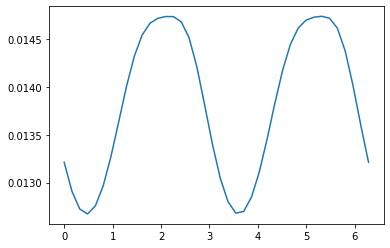

In [6]:
plt.plot(np.linspace(0, 2*np.pi, 40), Cas_)